In [1]:
# args
SEQ_LEN = 12
FORECAST_HORIZON = 3
MULTI_HORIZON = True
INPUT_DIM = 1
CONV_OUTPUT_DIM = 8
LSTM_HID_DIM = 32
TRAIN_VALID_RATIO = 0.7
SEED = 42

In [2]:
import random
import pandas as pd
from constants import SAMPLE_ROUTES
import torch
import numpy as np
from utils import GraphTimeSeriesDataset, compute_adjacency_matrix
from models import GCN_LSTM
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import  List

torch.random.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
def get_route_distances(SAMPLE_ROUTES: List[int]):
    num_routes = len(SAMPLE_ROUTES)
    route_distances = pd.read_csv("PeMSD7_W_228.csv", header=None).to_numpy()
    route_distances = (route_distances[SAMPLE_ROUTES][:, SAMPLE_ROUTES])
    assert route_distances.shape == (num_routes, num_routes)

    speeds_array = pd.read_csv("PeMSD7_V_228.csv", header=None).to_numpy()
    speeds_array = speeds_array[:, SAMPLE_ROUTES]
    assert 2 == speeds_array.ndim
    assert speeds_array.shape[1] == num_routes
    return route_distances, speeds_array

In [4]:
def split_train_test(speeds_array: np.ndarray):
    split_idx = int(len(speeds_array) * TRAIN_VALID_RATIO)
    train_speeds_array = speeds_array[:split_idx]
    test_speeds_array = speeds_array[split_idx:]

    return train_speeds_array, test_speeds_array

In [5]:
(route_distances, 
 speeds_array) = get_route_distances(SAMPLE_ROUTES)
(train_speeds_array, 
 test_speeds_array) = split_train_test(speeds_array)

In [6]:
train_data = GraphTimeSeriesDataset(
    timeseries_data=train_speeds_array,
    seq_len=SEQ_LEN,
    forecast_horizon=FORECAST_HORIZON,
    multi_horizon=MULTI_HORIZON,
)

test_data = GraphTimeSeriesDataset(
    timeseries_data=test_speeds_array,
    seq_len=SEQ_LEN,
    forecast_horizon=FORECAST_HORIZON,
    multi_horizon=MULTI_HORIZON,
)

In [7]:
adj_mat = compute_adjacency_matrix(route_distances, sigma2=0.1, epsilon=0.5)
model = GCN_LSTM(
    input_dim=INPUT_DIM,
    conv_output_dim=CONV_OUTPUT_DIM,
    lstm_hid_dim=LSTM_HID_DIM,
    adj_mat=adj_mat,
    forecast_horizon=FORECAST_HORIZON,
    multi_horizon=MULTI_HORIZON,
)

In [8]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=16, shuffle=True
)

In [9]:
model.train()

optim = torch.optim.AdamW(model.parameters(), lr=0.0005)
losses=[]
for X, y in train_loader:
    pred_y = model(X)
    loss = F.mse_loss(pred_y, y)
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()


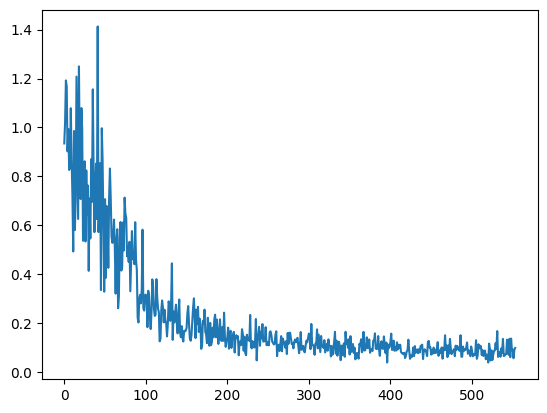

In [10]:
plt.plot(losses)
plt.show()

In [11]:
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=16, shuffle=False
)

In [12]:
model.eval()
y_preds = []
y_trues = []
losses = []
with torch.no_grad():
    for X, y in test_loader:
        pred_y = model(X)
        loss = F.mse_loss(pred_y, y)
        losses.append(loss.item())
        y_preds.append(pred_y.cpu().numpy()[0,:,0,:].reshape(-1))
        y_trues.append(y.cpu().numpy()[0,:,0,:].reshape(-1))
y_trues = np.concatenate(y_trues)
y_preds = np.concatenate(y_preds)

In [13]:
np.array(losses).mean()

0.09802100181438123

In [14]:
pred_y.shape

torch.Size([11, 3, 26, 1])

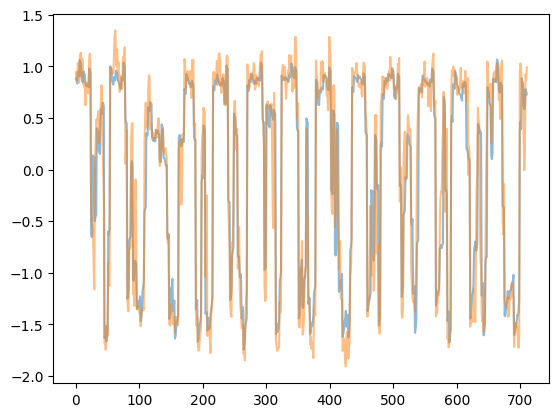

In [15]:
plt.plot(y_preds[:5000], alpha=0.5)
plt.plot(y_trues[:5000], alpha=0.5)